#### 导入必要的包

In [45]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils import data
from torchvision import transforms

#### 创建累加器

In [7]:
class Accumulator:
    """对n个变量进行累加操作"""

    def __init__(self, n):
        # 初始化累加器数据
        self.data = [0.0] * n

    def add(self, *args):
        # 将data列表中的每个元素a与args中对应位置的参数b相加，得到新的元素值，组成新的列表
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        # 重置累加器数据
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        # 获取累加器数据
        return self.data[idx]

# 多层感知机

## 加载数据

In [32]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集并将其加载到内存中"""

    # 创建存储图像转换操作的列表，包含ToTensor实例
    trans = [transforms.ToTensor()]

    if resize:
        trans.insert(0, transforms.Resize(resize))  # 将Resize实例加入转换列表
    trans = transforms.Compose(trans)  # 将多个图像转换的操作合并

    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False))

In [33]:
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 定义模型

In [5]:
from torch import nn
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))


def init_weight(m):
    """对权重正态分布初始化"""
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

## 损失函数

In [7]:
loss = nn.CrossEntropyLoss()

## 优化算法

In [9]:
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr=lr)

## 训练函数

In [12]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""

    # 设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

        # 初始化
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        batch_loss = loss(y_hat, y)
        updater.zero_grad()
        batch_loss.backward()  # 反向传播
        updater.step()  # 更新参数

        total_loss += batch_loss.item() * y.numel()  # 计算训练集总损失
        total_correct += (y_hat.argmax(1) == y).sum().item()  # 计算正确预测总数
        total_samples += y.numel()  # 计算总样本数

    average_loss = total_loss / total_samples  # 计算训练集上平均损失

    # 计算训练集上的准确度
    train_acc = total_correct / total_samples

    # 返回平均损失和训练集上的准确度
    return average_loss, train_acc

In [32]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    # 创建空列表用于存储评估指标
    epochs = []
    losses = []
    train_acc_ = []
    test_acc_ = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)

        epochs.append(epoch + 1)
        losses.append(train_loss)
        train_acc_.append(train_acc)
        test_acc_.append(test_acc)

        train_loss = round(train_loss, 4)
        train_acc = round(train_acc, 4)
        test_acc = round(test_acc, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={train_loss} Train Accuracy={train_acc} Test Accuracy={test_acc}')

        # 可视化
    plt.figure(figsize=(8, 6))

    plt.plot(epochs, losses, 'o-', color='#39C5BB', lw=2, label='Loss')
    plt.plot(epochs, train_acc_, '.--', color='#FFE211',
             lw=2, label='Train Accuracy')
    plt.plot(epochs, test_acc_, '.--', color='#FAAFBE',
             lw=2, label='Test Accuracy')

    plt.xticks(np.arange(0, num_epochs+1, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(axis='y')

    plt.show()

    print('训练完成！')

## 评估函数

In [42]:
def accuracy(y_hat, y):
    """计算正确预测的数量"""

    # 获取模型预测的分类标签（概率最大的类别）
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)

    # 判断是否预测正确
    cmp = (y_hat.type(y.dtype) == y)

    # 输出正确预测的总数
    return float(cmp.sum())

In [43]:
def evaluate_accuracy(net, data_iter):
    """计算模型准确度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式

    # 初始化
    total_accuracy = 0
    total_sample = 0

    with torch.no_grad():
        for X, y in data_iter:
            total_accuracy += accuracy(net(X), y)  # 添加正确预测数
            total_sample += y.numel()  # 添加样本数

    # 返回预测正确率
    return total_accuracy / total_sample

## 训练

epoch[1/10], loss=0.5996 Train Accuracy=0.7898 Test Accuracy=0.8004
epoch[2/10], loss=0.5195 Train Accuracy=0.8187 Test Accuracy=0.7959
epoch[3/10], loss=0.48 Train Accuracy=0.8323 Test Accuracy=0.7414
epoch[4/10], loss=0.4549 Train Accuracy=0.8406 Test Accuracy=0.8299
epoch[5/10], loss=0.4303 Train Accuracy=0.8479 Test Accuracy=0.834
epoch[6/10], loss=0.4161 Train Accuracy=0.8535 Test Accuracy=0.843
epoch[7/10], loss=0.402 Train Accuracy=0.8581 Test Accuracy=0.8411
epoch[8/10], loss=0.3902 Train Accuracy=0.8614 Test Accuracy=0.8459
epoch[9/10], loss=0.3812 Train Accuracy=0.8645 Test Accuracy=0.8526
epoch[10/10], loss=0.3738 Train Accuracy=0.8679 Test Accuracy=0.8521


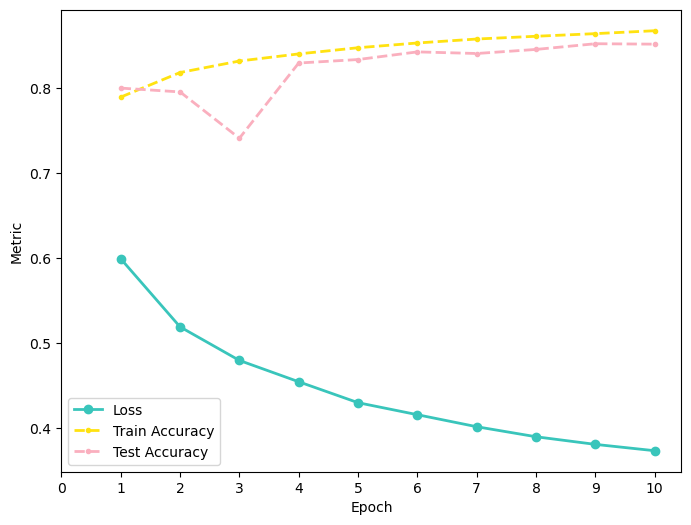

训练完成！


In [23]:
num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, trainer)

# 正则化

## 生成数据

In [21]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 添加一些噪声
    return X, y.reshape((-1, 1))

In [22]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  # "*"表示解压可迭代对象
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [23]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5  # 设置200维输入
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

## 评估函数

In [24]:
def evaluate_loss(net, data_iter, loss):
    """评估在指定数据集上模型的损失"""
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

## 训练函数

In [28]:
def train(wd):
    """带正则化训练模型"""

    net = nn.Sequential(nn.Linear(num_inputs, 1))

    # 初始化模型参数
    for param in net.parameters():
        param.data.normal_()

    # 损失函数
    loss = nn.MSELoss(reduction='none')

    # 训练轮数，学习率
    num_epochs, lr = 100, 0.003

    # 优化器
    trainer = optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}], lr=lr)  # 不对偏置参数正则化

    # 创建空列表存储损失
    epochs = []
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()

        train_loss = evaluate_loss(net, train_iter, loss)
        test_loss = evaluate_loss(net, test_iter, loss)

        epochs.append(epoch+1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    print('w的L2范数', net[0].weight.norm().item())

    # 绘制损失曲线
    plt.plot(epochs, train_losses, label='train loss')
    plt.plot(epochs, test_losses, label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

## 训练

w的L2范数 12.703042984008789


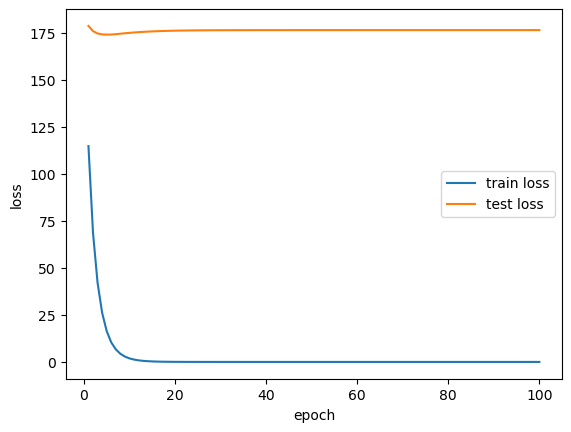

In [29]:
# 不使用正则化
train(0)

w的L2范数 0.3658447563648224


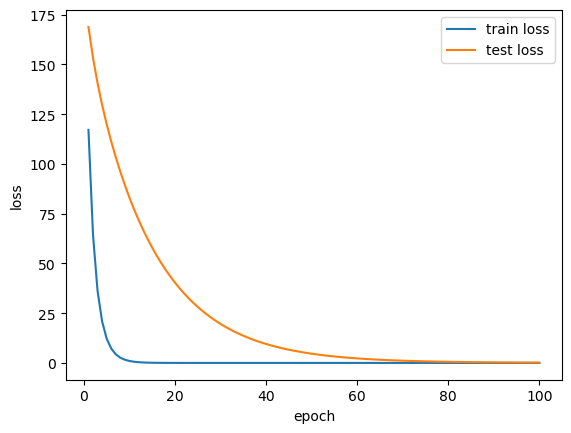

In [31]:
# 使用正则化
train(3)

# Dropout

## 加载数据

In [34]:
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 模型参数

In [46]:
# 输入层、输出层、隐藏层维度
input_dim = 28 * 28
hidden1_dim = 256
hidden2_dim = 256
output_dim = 10

# dropout概率
dropout1 = 0.5
dropout2 = 0.2

## 定义模型

In [50]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(input_dim, hidden1_dim),
                    nn.ReLU(),
                    # 在第一个全连接层后添加Dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(hidden1_dim, hidden2_dim),
                    nn.ReLU(),
                    # 在第二个全连接层后添加Dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(hidden2_dim, output_dim))

# 初始化模型参数


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

## 损失函数

In [51]:
loss = nn.CrossEntropyLoss()

## 优化算法

In [52]:
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

## 训练函数

In [53]:
def train_epoch(net, train_iter, loss, optimizer):
    """训练模型一个迭代周期"""

    # 设置为训练模式
    net.train()

    # 初始化
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        batch_loss = loss(y_hat, y)
        optimizer.zero_grad()
        batch_loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        total_loss += batch_loss.item() * y.numel()  # 计算训练集总损失
        total_correct += (y_hat.argmax(1) == y).sum().item()  # 计算正确预测总数
        total_samples += y.numel()  # 计算总样本数

    # 计算训练集上平均损失
    average_loss = total_loss / total_samples

    # 计算训练集上的准确度
    train_acc = total_correct / total_samples

    # 返回平均损失和训练集上的准确度
    return average_loss, train_acc

In [54]:
def train(net, train_iter, test_iter, loss, num_epochs, optimizer):
    """训练模型"""
    # 创建空列表用于存储评估指标
    epochs = []
    losses = []
    train_acc_ = []
    test_acc_ = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)

        epochs.append(epoch + 1)
        losses.append(train_loss)
        train_acc_.append(train_acc)
        test_acc_.append(test_acc)

        train_loss = round(train_loss, 4)
        train_acc = round(train_acc, 4)
        test_acc = round(test_acc, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={train_loss} Train Accuracy={train_acc} Test Accuracy={test_acc}')

        # 可视化
    plt.figure(figsize=(8, 6))

    plt.plot(epochs, losses, 'o-', color='#39C5BB', lw=2, label='Loss')
    plt.plot(epochs, train_acc_, '.--', color='#FFE211',
             lw=2, label='Train Accuracy')
    plt.plot(epochs, test_acc_, '.--', color='#FAAFBE',
             lw=2, label='Test Accuracy')

    plt.xticks(np.arange(0, num_epochs+1, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(axis='y')

    plt.show()

    print('训练完成！')

## 训练

epoch[1/10], loss=1.7563 Train Accuracy=0.3212 Test Accuracy=0.5916
epoch[2/10], loss=0.8936 Train Accuracy=0.6603 Test Accuracy=0.7484
epoch[3/10], loss=0.6956 Train Accuracy=0.7432 Test Accuracy=0.758
epoch[4/10], loss=0.5976 Train Accuracy=0.7837 Test Accuracy=0.8065
epoch[5/10], loss=0.5401 Train Accuracy=0.8076 Test Accuracy=0.8144
epoch[6/10], loss=0.5015 Train Accuracy=0.8238 Test Accuracy=0.8269
epoch[7/10], loss=0.4728 Train Accuracy=0.8308 Test Accuracy=0.8324
epoch[8/10], loss=0.454 Train Accuracy=0.8377 Test Accuracy=0.8357
epoch[9/10], loss=0.438 Train Accuracy=0.8444 Test Accuracy=0.8441
epoch[10/10], loss=0.4259 Train Accuracy=0.8474 Test Accuracy=0.841


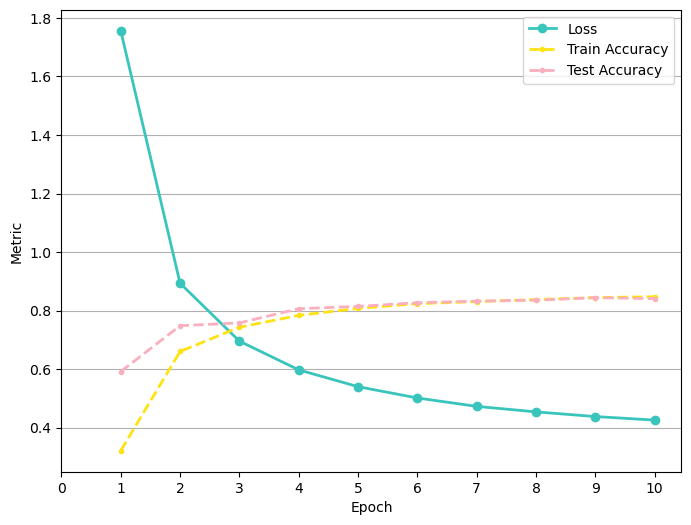

训练完成！


In [55]:
num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, optimizer)

# 练习：鸢尾花分类

In [130]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 加载数据

In [132]:
# 读取数据集
iris = load_iris()
X, y = iris.data, iris.target

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8964)

# 转换为张量
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# 加载数据
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [133]:
X_train.shape

torch.Size([120, 4])

## 定义模型

In [134]:
net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, output_dim))

# 设置输入层、隐藏层、输出层维度
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = len(iris.target_names)

# 权重初始化


def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


# 定义损失函数和优化器
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## 训练函数

In [135]:
def train_epoch(net, train_loader, loss, optimizer):
    """训练模型一个迭代周期"""

    net.train()  # 设为训练模式

# 初始化
    total_loss = 0.0
    train_correct = 0
    train_samples = 0
    test_correct = 0
    test_samples = 0

    for X, y in train_loader:
        # 计算梯度并更新参数
        y_hat = net(X)
        batch_loss = loss(y_hat, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item() * y.numel()  # 计算训练集总损失
        train_correct += (y_hat.argmax(1) == y).sum().item()  # 计算训练集正确预测总数
        train_samples += y.numel()  # 计算训练集总样本数

    train_loss = total_loss / train_samples  # 计算训练集平均损失
    train_acc = train_correct / train_samples  # 计算训练集准确度

    # 计算测试集上的准确度
    net.eval()  # 设为评估模式
    with torch.no_grad():
        for X, y in test_loader:
            y_hat = net(X)
            test_correct += (y_hat.argmax(1) == y).sum().item()  # 计算测试集正确预测总数
            test_samples += y.numel()  # 计算测试集总样本数

        test_acc = test_correct / test_samples  # 计算测试集准确度

# 返回训练集平均损失、训练集准确度、测试集准确度
    return train_loss, train_acc, test_acc

In [136]:
def train(net, train_loader, test_loader, loss, num_epochs, optimizer):
    """训练模型"""
    # 创建空列表用于存储评估指标
    epochs = []
    losses = []
    train_acc_ = []
    test_acc_ = []

    for epoch in range(num_epochs):
        train_loss, train_acc, test_acc = train_epoch(
            net, train_loader, loss, optimizer)

        epochs.append(epoch + 1)
        losses.append(train_loss)
        train_acc_.append(train_acc)
        test_acc_.append(test_acc)

        train_loss = round(train_loss, 4)
        train_acc = round(train_acc, 4)
        test_acc = round(test_acc, 4)

        print(
            f'epoch[{epoch + 1}/{num_epochs}], loss={train_loss} Train Accuracy={train_acc} Test Accuracy={test_acc}')

        # 可视化
    plt.figure(figsize=(12, 5))

    plt.plot(epochs, losses, '.-', color='#39C5BB', lw=2, label='Loss')
    plt.plot(epochs, train_acc_, '.--', color='#FFE211',
             lw=2, label='Train Accuracy')
    plt.plot(epochs, test_acc_, '.--', color='#FAAFBE',
             lw=2, label='Test Accuracy')

    plt.xticks(np.arange(0, num_epochs+1, 10))
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(axis='y')

    plt.show()

    print('训练完成！')

## 训练

epoch[1/100], loss=1.103 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[2/100], loss=1.0995 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[3/100], loss=1.0954 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[4/100], loss=1.0893 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[5/100], loss=1.0813 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[6/100], loss=1.0681 Train Accuracy=0.3417 Test Accuracy=0.3
epoch[7/100], loss=1.0518 Train Accuracy=0.45 Test Accuracy=0.6333
epoch[8/100], loss=1.0297 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[9/100], loss=1.0016 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[10/100], loss=0.9703 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[11/100], loss=0.9345 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[12/100], loss=0.8956 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[13/100], loss=0.8568 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[14/100], loss=0.8163 Train Accuracy=0.675 Test Accuracy=0.6333
epoch[15/100], loss=0.7744 Train Accuracy=0.675 Test Accu

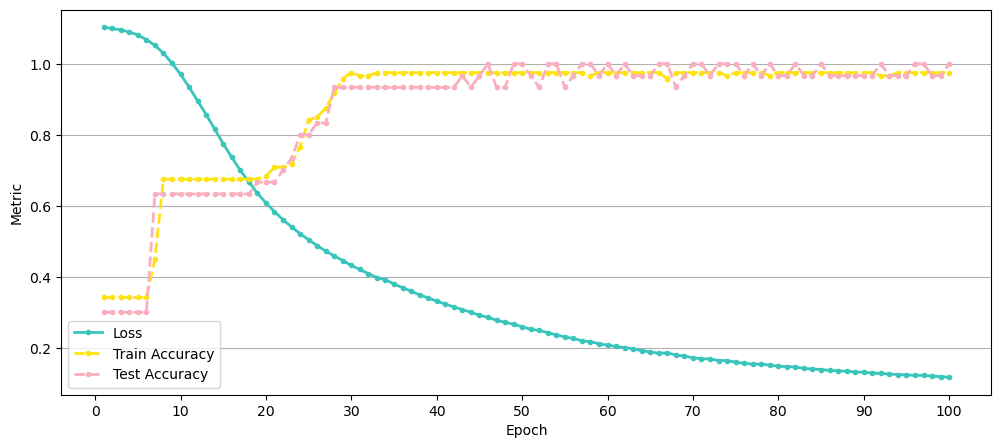

训练完成！


In [137]:
# 设置训练轮数
num_epochs = 100

# 权重初始化
net.apply(init_weight)

# 开始训练
train(net, train_loader, test_loader, loss, num_epochs, optimizer)